# M1 ML - Science des données - Projet


# Author :

    * Pather Stevenson
    * Bilon Audrey

# 1- Librairies

In [113]:
import os
from joblib import dump, load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# 2 - Data pre-processing

## 2.1 - Récupération des données

In [114]:
emotion = pd.read_csv("CK+/emotion.csv",sep=";")
classes = pd.read_csv("CK+/classes.csv",sep=",")

In [115]:
folder = os.listdir('CK+/')
folder.remove("emotion.csv")
folder.remove("classes.csv")

## 2.2 - Génération des dataframes à partir des données

In [116]:
def generate_columns_dict(n):
    """
    
    generate a dictionnary with key:value {i: x_i, i+1 : y_i} for i from 1 to (n*2)+1
    with a step of 2 in order to assign the x and y coordinate number to dataframe
    
    :param n: the last point number of data (68 in our project)
    :type n: int
    
    :return: the dict generated
    :rtype: dict
    """
    d = {}
    j = 1
    for i in range(1,(n*2)+1,2):
        d[i] = f"x{j}"
        d[i+1] = f"y{j}"
        j += 1
    return d

In [117]:
def generate_dataframe(folder,selection,only_apex=False,center=False,apex_dist=False,mid_pt=27):
    """
    :param folder: list of subject folder directory
    :param selection: the selected subject session
    :param only_apex: True to indicate if we only keep the apex image (the last image of each session), otherwise False
    :param center: True to indicate that we want to center (x,y) coordinates
                   compared with the 28th points of neutral image of each sessions, otherwise False
    :param apex_dist: True to only keep the distance between the neutral image and the apex image of each sessions, otherwise False
    :type folder: List
    :type selection: pandas.DataFrame
    :type only_apex: Bool
    :type center: Bool
    :type apex_dist: Bool
    
    :return: a final dataframe from data
    :rtype: pandas.DataFrame
    """
    df = pd.DataFrame()
    
    x_index = [x for x in range(1,137,2)]
    y_index = [y for y in range(2,137,2)]
    
    for f in folder:
        
        omlands = pd.read_csv(f'CK+/{f}/omlands.csv',sep=";",header=None).iloc[:,:-1].rename(columns={0: "file"})
        neutral_index = omlands.groupby("file").apply(lambda s : s.first_valid_index()).values 
        n = len(neutral_index)
        
        if center:    
            for i in range(n):
                
                start = neutral_index[i]
                end = neutral_index[i+1]-1 if (n != 1 and i != n-1) else -1
                
                x_neutral, y_neutral = omlands.iloc[start,1:].values.reshape(68,2)[mid_pt]
                omlands.iloc[start:end,x_index] = omlands.iloc[start:end,x_index].apply(lambda x : x_neutral - x)
                omlands.iloc[start:end,y_index] = omlands.iloc[start:end,y_index].apply(lambda y : y_neutral - y)

        if only_apex or apex_dist:
            index = omlands.groupby("file").apply(lambda s : s.last_valid_index()).values
            
            if apex_dist:
                omlands.iloc[index,1:] = omlands.iloc[index,1:] - omlands.iloc[neutral_index,1:].values
            
            omlands = omlands.iloc[index]

        else:
            omlands = omlands.iloc[1:]
            omlands.drop(omlands.index[neutral_index], inplace=True)
        
        df = pd.concat([df,omlands.assign(subject=f'{f}')])
        
    df = df.rename(columns={0: "file"})
    df = df.rename(columns=generate_columns_dict(68))
    df = pd.merge(selection,df,on=["subject","file"])
    
    return df

In [118]:
def plt_face(coord,title,lim=False):
    """
    plot a fives given face representation by coordinate pts
    
    :param coord: nd.array of a coordinates point that represent faces
    :param lim: set xlim ylim if True, otherwise False
    :type coord: ndarray
    :type lim: Bool
    """
    figure, axis = plt.subplots(1, len(coord),figsize=(20,5))
    
    for i in range(len(coord)):
        
        axis[i].scatter(coord[i].reshape(68,2)[:,0],coord[i].reshape(68,2)[:,1])
        
        axis[i].invert_yaxis()
        
    if lim:
        plt.xlim([0,1100])
        plt.ylim([950,300])
            
    figure.suptitle(title,fontsize=15)

**Description des dataframes générés :**
$\newline$
* *df_all* contient les données non centrées des images les moins expressives au plus expressives (image apex incluse) par expression et par session,
* *df_apex* contient les données non centrées des images apex uniquement par expression et par session,
* *df_all_center* contient les données centrées des images les moins expressives au plus expressives (image apex incluse) par expression et par session,
* *df_apex_center* contient les données centrées des images apex par expression et par session
* *df_apex_dist* contient les données pour chaque session la différence entre l'image apex et l'image neutre de celles-ci
$\newline$

**Remarque :**
$\newline$
* Dans tous les cas, la première image de chaque session, qui est une image d'expression neutre, est retirée des données pour ne pas biaiser l'entraînement de nos modèles, étant donné que la catégorie neutre n'est pas une émotion à prédire ici.
* Le centrage des données est effectué effectuant la soustraction des coordonnées de chaque image de session avec le point $(x28,y28)$ de l'image neutre de la session respective. Dans le cas du dataframes où l'on ne considére que les images apex (df_apex_center) c'est alors la considération du déplacement des points entre l'image neutre et l'image apex uniquement.

In [119]:
df_all = generate_dataframe(folder,emotion)
df_apex = generate_dataframe(folder,emotion,only_apex=True)
df_all_center = generate_dataframe(folder,emotion,center=True)
df_apex_center = generate_dataframe(folder,emotion,only_apex=True,center=True)
df_apex_dist = generate_dataframe(folder,emotion,apex_dist=True)

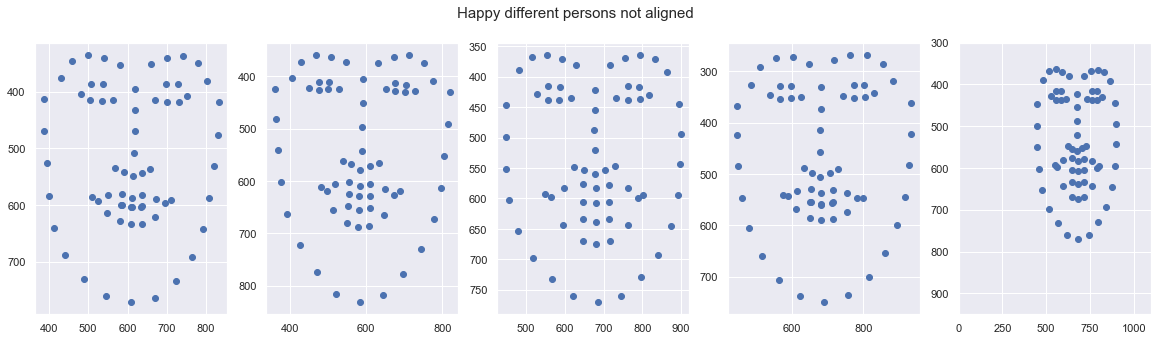

In [8]:
coord = df_apex[df_apex['emotion']==1].loc[:,'x1':].values
plt_face(coord[np.random.choice(np.arange(len(coord)),5)],"Happy different persons not aligned",lim=True)

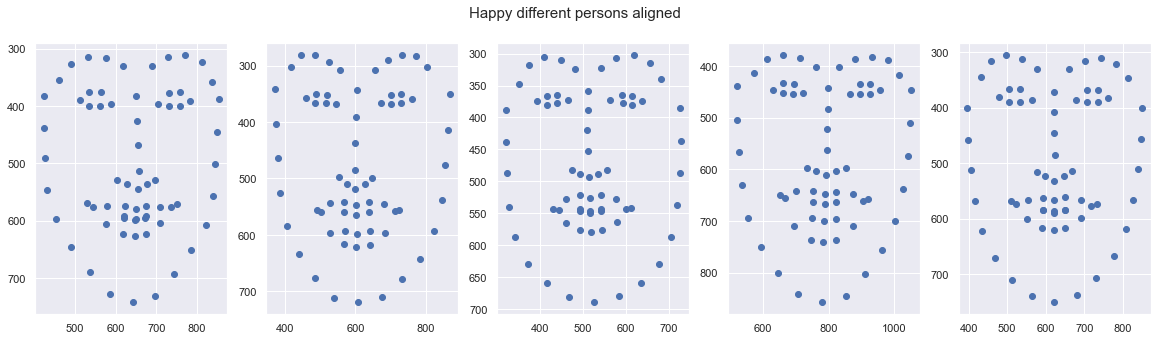

In [9]:
coord_center = df_apex_center[df_apex_center['emotion']==1].loc[:,'x1':].values
plt_face(coord_center[np.random.choice(np.arange(len(coord_center)),5)],"Happy different persons aligned")

* Nous pouvons constater que le centrage des images est bien correct

## 2.3 - Contrôle et analyse des données

In [10]:
df_all.nunique(axis=0)

subject     99
file         9
emotion      6
x1         276
y1         236
          ... 
y66        303
x67        289
y67        314
x68        289
y68        301
Length: 139, dtype: int64

In [11]:
df_all.describe()

,file,emotion,x1,y1,x2,y2,x3,y3,x4,y4,...,x64,y64,x65,y65,x66,y66,x67,y67,x68,y68
count,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,...,6163.000000,6163.000000,6163.000000,6163.000000,6163.00000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000
mean,3.348856,3.092163,404.634269,413.371086,408.896479,471.506571,417.429985,529.005517,427.989291,586.485153,...,655.205257,609.753529,704.543242,618.408567,655.25864,625.969820,630.805290,629.210287,607.430310,625.887393
std,1.928533,1.809297,59.857490,46.667671,59.424490,45.739839,58.973055,45.435156,58.886058,45.789276,...,55.401399,49.417054,56.585471,50.002368,55.24396,53.825457,55.455209,54.221527,56.100377,53.806459
min,1.000000,1.000000,256.000000,290.000000,264.000000,355.000000,274.000000,411.000000,287.000000,465.000000,...,516.000000,468.000000,547.000000,476.000000,517.00000,476.000000,504.000000,477.000000,486.000000,476.000000
25%,2.000000,1.000000,365.000000,383.000000,370.000000,441.500000,378.000000,497.000000,388.000000,553.000000,...,619.000000,575.000000,668.000000,584.000000,619.00000,589.000000,595.000000,592.000000,571.000000,589.000000
50%,3.000000,3.000000,396.000000,412.000000,401.000000,471.000000,407.000000,528.000000,418.000000,585.000000,...,646.000000,607.000000,695.000000,614.000000,646.00000,619.000000,621.000000,622.000000,599.000000,619.000000
75%,5.000000,5.000000,437.000000,452.000000,439.000000,507.000000,445.000000,564.000000,455.000000,622.000000,...,685.000000,648.000000,734.000000,654.000000,686.00000,667.000000,660.000000,670.000000,638.000000,667.000000
max,9.000000,6.000000,637.000000,543.000000,640.000000,594.000000,645.000000,643.000000,657.000000,702.000000,...,846.000000,724.000000,906.000000,748.000000,846.00000,810.000000,820.000000,814.000000,800.000000,806.000000


In [12]:
df_all_center.describe()

,file,emotion,x1,y1,x2,y2,x3,y3,x4,y4,...,x64,y64,x65,y65,x66,y66,x67,y67,x68,y68
count,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,...,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000,6163.000000
mean,3.348856,3.092163,235.651468,7.631997,231.863703,-43.648386,224.301801,-94.387311,214.986046,-145.128996,...,14.302288,-166.343826,-29.187246,-173.571962,14.282006,-179.348045,35.743631,-182.201363,56.250852,-179.296122
std,1.928533,1.809297,55.418966,103.486964,56.702034,130.016233,59.604213,156.692091,63.471012,183.603434,...,161.772827,193.402586,185.269378,198.642024,161.885893,204.667965,150.241559,206.266672,139.267537,204.609891
min,1.000000,1.000000,-330.000000,-428.000000,-339.000000,-492.000000,-354.000000,-557.000000,-366.000000,-623.000000,...,-616.000000,-653.000000,-671.000000,-667.000000,-619.000000,-689.000000,-587.000000,-695.000000,-556.000000,-693.000000
25%,2.000000,1.000000,214.000000,-28.000000,209.000000,-85.000000,201.000000,-143.000000,190.000000,-202.000000,...,-28.000000,-228.000000,-81.000000,-239.000000,-28.000000,-244.000000,-3.000000,-248.000000,19.000000,-244.000000
50%,3.000000,3.000000,229.000000,-16.000000,225.000000,-74.000000,217.000000,-131.000000,207.000000,-188.000000,...,-22.000000,-212.000000,-69.000000,-218.000000,-22.000000,-223.000000,1.000000,-226.000000,24.000000,-223.000000
75%,5.000000,5.000000,245.000000,-1.000000,240.000000,-59.000000,231.000000,-116.000000,220.000000,-171.000000,...,-18.000000,-192.000000,-60.000000,-197.000000,-18.000000,-203.000000,5.000000,-205.000000,29.000000,-202.000000
max,9.000000,6.000000,637.000000,531.000000,640.000000,584.000000,645.000000,635.000000,657.000000,695.000000,...,846.000000,722.000000,906.000000,747.000000,846.000000,799.000000,819.000000,804.000000,797.000000,801.000000


* Le centrage des données permet de réduire l'écart entre les données. On peut observer cette normalisation de nos points au travers des moyennes de chaque x et y mais également avec les valeurs min max et l'écart type.

In [13]:
emotion.isna().sum().sum(), df_all.isna().sum().sum(), df_apex.isna().sum().sum()

(0, 0, 0)

In [14]:
df_all_center.isna().sum().sum(), df_apex_center.isna().sum().sum(), df_apex_dist.isna().sum().sum()

(0, 0, 0)

In [15]:
emotion.isnull().sum().sum(), df_all.isnull().sum().sum(), df_apex.isnull().sum().sum()

(0, 0, 0)

In [16]:
df_all_center.isnull().sum().sum(), df_apex_center.isnull().sum().sum(), df_apex_dist.isnull().sum().sum()

(0, 0, 0)

* Ici nous pouvons observer qu'aucune valeur NULL n'est présente dans nos dataframes générés directement à partir des données et également après modification pour le centrage de celles-ci.

In [120]:
def plt_reprensetation(df,df_name,classes_label=classes):
    """
    show the represensation of each given classes label given for each given dataframe in df
    
    :param df: list of dataframe to analyse
    :param df_name: name in order of each dataframe in df 
    :param classes_label: the dataframe of corresponding label of classes value (default value the classes dataframe created from "CK+/classes.csv"
    
    :type df: pandas.Dataframe
    :type df_name: List
    :type classes_label: pandas.Dataframe
    
    :sideeffect: print graph with matplotlib lib
    
    :return: Nothing
    :rtype: None
    """
    for i in range(len(df)):
        d = df[i]
        label = df_name[i]
        
        fig , ax = plt.subplots(figsize=(12,5))
        
        sns.countplot(x='emotion', data=d, order = d['emotion'].value_counts(ascending=False).index)

        name = classes['emotion'].values[d['emotion'].value_counts().index-1]
        pourcent = d['emotion'].value_counts(ascending=False, normalize=True).values * 100

        ax.bar_label(container=ax.containers[0],labels=[f'{p[0]} ({p[1]:.2f}%)' for p in zip(name, pourcent)])

        plt.title(f"Représentation des émotions dans {label}",fontsize=20)
        plt.show()

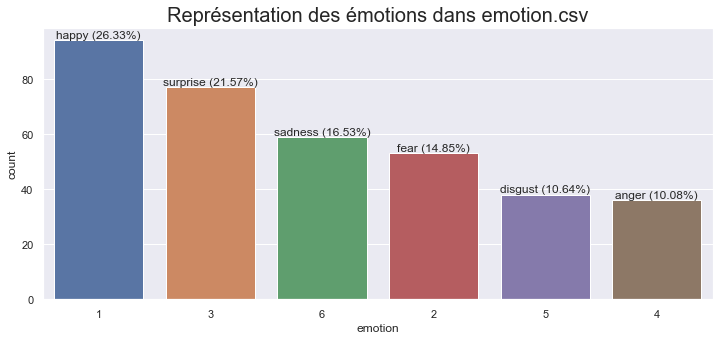

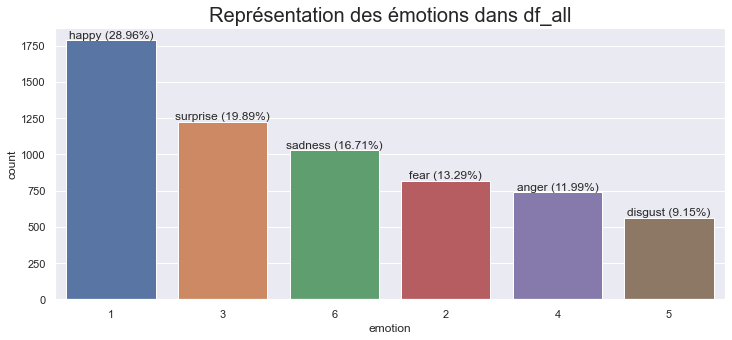

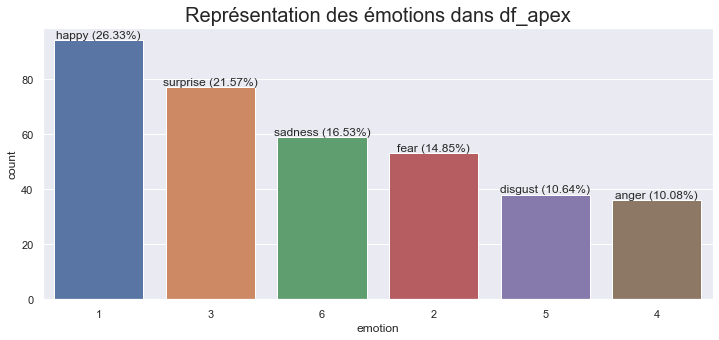

In [19]:
plt_reprensetation([emotion,df_all,df_apex],['emotion.csv','df_all','df_apex'])

* A l'aide de ces graphique nous pouvons constater la représentation de chaque émotion de la sélection des données demandée dans le fichier *CK+/emotion.csv*.

* Les expressions happy et surprise sont dominantes dans nos images de visage. Les autres émotions ont au plus 6% de représentation de différence dans les données.

* Pour le dataframe *df_all* les représentations sont à $\pm 1\%$ les mêmes que pour le dataframe *emotion*, on peut noter tout de même une augmentation de 2% de la présence de l'expression happy

* Les représentation des dataframe *emotion* et *df_apex* sont égales car étant donner que *df_apex* ne contient qu'une seule image par expression par session alors ont obtient le même nombre d'occurrence pour la colonne "emotion" des deux dataframes.

* Ainsi on peut noter également que les dataframes contenant que les images apex possédent 357 images de par la sélection des sessions demandés dans emotion.csv alors que dans les dataframes où toutes les images sont considérés (hormis les images neutres) nous avons 6163 images.

In [121]:
def get_correlation_drop(df,threshold,show=False,palette=True,method='pearson'):
    """
    Return the list of columns in the dataframe to conserve in function
    of the given threshold correlation
    
    :param df: the dataframe
    :param threshold: the threshold for which attributs must be stricly superior to
    :param show: True to show heatmap, False otherwise
    :param palette: True to use palette color for -1 / 1 
    :param method: method to use to create the correlation matrix
    
    :type df: pd.DataFrame
    :type threshold: Float
    :type show: Bool
    :type palette: Bool
    
    :return: the list that contains all the columns name of df which have a strictly
             superior correlation degree to the given threshold
    :rtype: List
    """
    cor_matrix = df.loc[:,'x1':].corr(method=method)
    p = None
    
    if palette: 
        p = sns.diverging_palette(1, 1, as_cmap=True)
    if show:
        sns.heatmap(cor_matrix,cmap=p)
    
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
    
    return [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]

* Cette fonction va nous permettre de retirer de nos dataframes les attributs qui ont un seuil de corrélation supérieur à un seuil donné en argument et conclure sur la pertinance de la conservation de ceux-ci dans nos données.

## 2.4 - Préparation des données pour l'apprentissage

In [122]:
from sklearn.preprocessing import StandardScaler

In [123]:
X_all, y_all = df_all.loc[:,'x1':].values, df_all['emotion'].values
X_all = StandardScaler().fit_transform(X_all,y_all)

In [124]:
X_all_center, y_all_center = df_all_center.loc[:,'x1':].values, df_all_center['emotion'].values
X_all_center = StandardScaler().fit_transform(X_all_center,y_all_center)

In [125]:
X_apex, y_apex = df_apex.loc[:,'x1':].values, df_apex['emotion'].values
X_apex = StandardScaler().fit_transform(X_apex,y_apex)

In [126]:
X_apex_center, y_apex_center = df_apex_center.loc[:,'x1':].values, df_apex_center['emotion'].values
X_apex_center = StandardScaler().fit_transform(X_apex_center,y_apex_center)

In [127]:
X_apex_dist, y_apex_dist = df_apex_dist.loc[:,'x1':].values, df_apex_dist['emotion'].values
X_apex_dist = StandardScaler().fit_transform(X_apex_dist,y_apex_dist)

In [128]:
data = [(X_all,y_all,'df_all'), (X_all_center,y_all_center,'df_all_center'),(X_apex,y_apex,'df_apex'), (X_apex_center,y_apex_center,'df_apex_center'),  (X_apex_dist,y_apex_dist,'df_apex_dist')]

* Nous prenons soins de standardiser nos données avant de les exploiter.
* On fait le choix de le faire ici pour ne pas effectuer via un pipeline pour chaque modèle la standardisation qui serait faite trop souvent alors que nous pouvons le faire une fois pour chaque type de df ici.

# 3 - Première approche

## 3.0 - import sklearn

In [129]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [130]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

## 3.1 - Recherche de modèles

### Remarque : Dans un premier temps, nous souhaitons trouver un modèle qui permet d'obtenir des résultats satisfaisant sans optimisation des hyperparamètres.

In [131]:
models = [RandomForestClassifier(), SVC(), DecisionTreeClassifier(), 
          SGDClassifier(), KNeighborsClassifier(), GaussianNB(), 
          LogisticRegression(n_jobs=-1), MLPClassifier(max_iter=1000), DummyClassifier(strategy="most_frequent")]

In [132]:
colors = {'RandomForestClassifier': 'peru','SVC': 'brown', 'GaussianNB': 'blue', 
          'DecisionTreeClassifier':'orange', 'SGDClassifier':'green','KNeighborsClassifier':'red',
          'LogisticRegression':'purple', 'MLPClassifier' : 'lightcoral', 'DummyClassifier' :'magenta'}

Ainsi nous allons sélectionner un modèle parmis ceux-ci :

* RandomForestClassifier
* SVC
* DecisionTreeClassifier
* SGDClassifier
* LogisticRegression
* KNeighborsClassifier
* GaussianNB
* MLPClassifier

En se basant sur leur score en cross-validation, puis en fonction de leur temps d'apprentissage et de prédiction en fonction de la taille de l'échantillon donné.

La présence d'un DummyClassifier avec pour stratégie la classe la plus fréquente a pour but de permettre une comparaison avec un modèle dit naïve de par sa stratégie de prédiction pour venir justifier ou non la nécessisté d'un modèle plus robuste.

In [133]:
def cv_score_multiple_sizes(estimators,X_train,y_train,sizes):
    """
    perform a cross-val using cross_val_score sklearn function for all given estimators and
    for all given training sizes to take in training sample
    
    :param estimators: list of all estimators to train
    :param X_train: the training samples
    :param y_train: labels to predict of the training sample
    :param sizes: list of sizes to take in training sample for the cross val
    
    :type estimators: List
    :type X_train: numpy.ndarray
    :type y_train: numpy.ndarray
    :type sizes: List
    
    :return: a dictionnary which contains (key, value) = (models_name, cv_score)
    :rtype: Dict
    """    
    cv = {m.__class__.__name__ : [] for m in models}
    rng = np.arange(len(X_train))
    
    for s in sizes:
        index = np.random.choice(rng,s)
        for m in estimators:
            cv[m.__class__.__name__] += [cross_val_score(m,X_train[index],y_train[index])]
    
    return cv

In [134]:
def plt_cv_scores(cv,sizes,title,colors):
    """
    plot the result of a performed cross-val between some estimators
    with given sizes of training samples
    
    :param cv: dict of result for each estimators
    :param sizes: sizes of training samples
    :param title: title of the graph
    :param colors: list of colors for each estiamtor curves
    
    :type cv: Dict
    :type sizes: List
    :type title: Str
    :type colors: List
    """
    fig, ax = plt.subplots(figsize=(5,5))

    for m in cv:
        ax.plot(sizes,[np.median(i) for i in cv[m]],label=f'{m}',color=colors[m])
        ax.fill_between(sizes,[min(i) for i in cv[m]],[max(i) for i in cv[m]],alpha=0.2,color=colors[m])
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.xlabel('Taille')
    plt.ylabel('Précision')

* Sur toutes les images (df_all et df_all_center) :

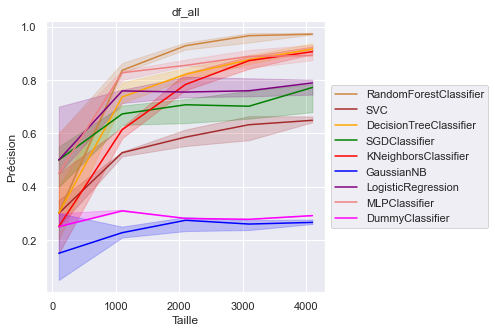

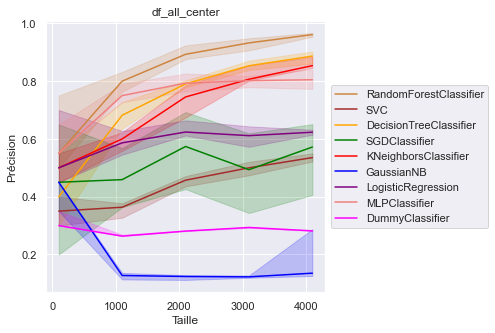

In [51]:
for X,y,label in data[:2]:
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.33)
    sizes = list(range(100,len(X_train),1000))
    cv = cv_score_multiple_sizes(models,X_train,y_train,sizes)
    plt_cv_scores(cv,sizes,label,colors)

* Le modèle GaussianNB n'est pas mieux qu'un DummyClassifier qui utilise une prédiction naïve par la classe la plus fréquente
* Les meilleurs modèles sont RandomForestClasifier, DecisionTreeClassifier, MLPClassifier et KNeighborsClassifier
* Le centrage des données dans le cas où l'on considère toutes les images ne permet pas d'obtenir une meilleure accuracy, celle-ci reste quasi inchangé dans le cas des 3 meilleurs modèles
* Le meilleur modèle en se basant sur ces deux graphiques est le RandomForestClassifier qui pour une taille d'échantillon presque maximale obtient une précision proche de $1$ avec ou sans centrage des données

* Sur les images apex (df_apex et df_apex_center, df_apex_dist) :

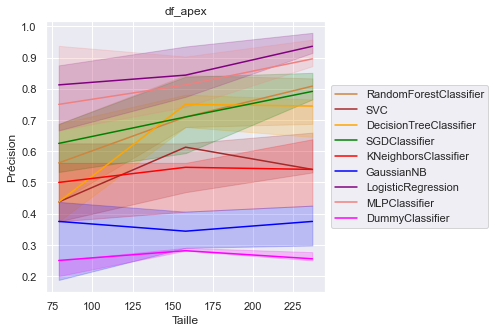

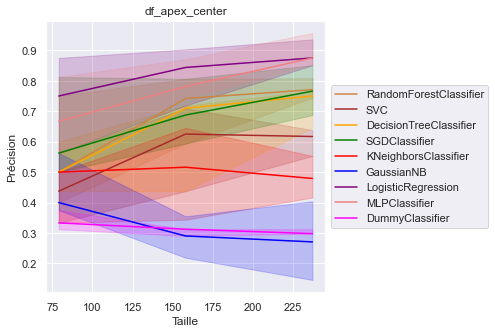

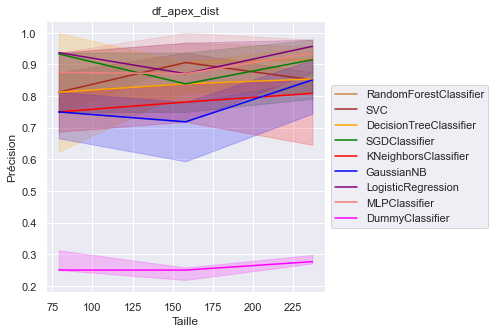

In [62]:
for X,y,label in data[2:]:
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.33)
    n = len(X_train)
    sizes = list(range(int(n/3),n,int(n/3)))
    cv = cv_score_multiple_sizes(models,X_train,y_train,sizes)
    plt_cv_scores(cv,sizes,label,colors)

* On constate qu'avec unique les images apex (centrées ou non) certains modèles n'ont pas une meilleure généralisation qu'avec toutes les images
* L'approche où l'on prend que l'image apex et où l'on effectue le différence entre l'image neutre et l'image apex (df_apex_dist) permet elle d'obtenir des précisions des modèles globalement tous au dessus de $0.8$. Ce qui constitue une bonne approche au vu des résultats sans cette approche.
* Dans cette partie on retient donc les modèles RandomForest, MLPClassifier et LogisticRegression.

Ainsi nous faisons le choix de sélectionner les 5 modèles suivants ,pour la suite de notre démarche, qui ressortent des deux observations effectuées précédemment :

* RandomForestClassifier
* DecisionTreeClassifier
* KNeighborsClassifier
* MLPClassifier
* LogisticRegression


In [23]:
models_selection = [RandomForestClassifier(n_jobs=-1), DecisionTreeClassifier(), 
                    KNeighborsClassifier(n_jobs=-1), MLPClassifier(max_iter=1000), 
                    LogisticRegression(max_iter=100,n_jobs=-1)]

### Mesurons maintenant le temps d'apprentissage et de prédiction de notre sélection : 

In [135]:
def get_fit_pred_time(models,X_train,y_train,sizes):
    """
    Returns the fitting and predicting time for each given models on
    given X_train,y_train data and given sizes of training samples
    
    :param models: list of estimator to measure
    :param X_train: the training samples
    :param y_train: labels to predict of the training sample
    :param sizes: list of sizes to take in training sample
    
    :type models: List
    :type X_train: numpy.ndarray
    :type y_train: numpy.ndarray
    :type sizes: List
    
    :return: the tuple (fit, predict) which contains the fiting and predicting time for each models
    :rtype: Tuple (Dict, Dict)
    """
    t_fit, t_predict = {m.__class__.__name__ : [] for m in models}, {m.__class__.__name__ : [] for m in models}
    rng = np.arange(len(X_train))
    
    for s in sizes:
        index = np.random.choice(rng,s)
        for m in models:
            
            r = %timeit -o -q -r1 -n1 m.fit(X_train[index],y_train[index])
            t_fit[m.__class__.__name__] += [r.timings]
        
            r = %timeit -o -q -r1 -n1 m.predict(X_train[index])
            t_predict[m.__class__.__name__] += [r.timings]
    
    return t_fit, t_predict

In [136]:
def plt_fit_pred_time(time_fit,time_predict,colors):
    """
    plot the result of a performed session measuring training
    and predicting time between some estimators
    
    :param time_fit: dict of fit time result for each estimators
    :param time_predict: dict of predict time result for each estimators
    :param colors: list of colors for each estiamtor curves
    
    :type time_fit: Dict
    :type time_predict: Dict
    :type colors: List
    """
    fig, axis = plt.subplots(1,2,figsize=(15,5))

    for m in t_fit:
        axis[0].plot(sizes,t_fit[m],label=f'{m}',color=colors[m])
        axis[1].plot(sizes,t_predict[m],label=f'{m}',color=colors[m])
    
    for ax in axis:
        ax.legend()
        ax.set_xlabel("Taille échantillon")
        ax.set_ylabel("Temps (s)")

    axis[0].set_title("Temps d'apprentissage en fonction de la taille")
    axis[1].set_title("Temps de prédiction en fonction de la taille")

* Pour la pertinence de notre observation, nous allons nous concentrer ici uniquement sur le dataframe df_all qui comporte un volume de données bien plus conséquent que df_apex qui ne contient que les images apex.

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,random_state=0,test_size=0.33)

In [146]:
t_fit, t_predict = get_fit_pred_time(models_selection,X_train,y_train,sizes)

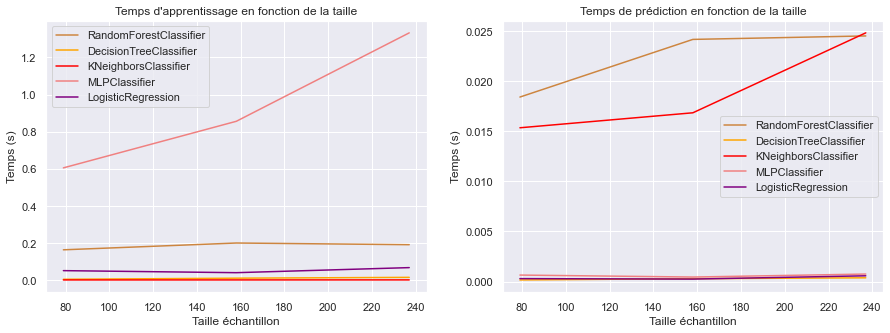

In [147]:
plt_fit_pred_time(t_fit,t_predict,colors)

**On peut constater que :**

* Le MLPClassifier a un temps d'apprentissage qui risque d'augmenter avec la taille de l'échantillon, nous ne considérons donc pas ce modèle dans le cas des dataframes avec toutes les images
* Les autres modèles montrent un temps d'apprentissage et de prédiction rapide et quasi constant 
* Hormis KNeighbors qui a ont un temps en prédiction qui croît avec la taille de l'échantillon.


## 3.2 - Hyper-parameters tuning

### Remarque : Nous allons maintenant effectuer une recherche des hyperparamètres par une recherche par grille dans le but d'améliorer nos modèles de prédiction

In [137]:
lr_param_grid = [{'penalty': ['l1', 'l2'],
                   'C': [1.0, 0.5, 0.1],
                   'solver': ['liblinear','newton-cg']}]

dt_param_grid = [{'criterion': ['gini', 'entropy'],
                   'min_samples_leaf': np.arange(1,7,2),
                   'max_depth': np.arange(1,18,4),
                   'min_samples_split': np.arange(2,8,2),
                   'splitter' : ['best','random']}]

rf_param_grid = [{'min_samples_leaf': np.arange(1,7,2),
                   'max_depth': np.arange(1,18,4),
                   'min_samples_split': np.arange(2,8,2)}]

knn_param_grid = [{'n_neighbors' : np.arange(3,22,2),
                 'weights' : ['uniform', 'distance'],
                  'metric' : ['euclidean','manhattan']}]

mlp_param_grid = [{'solver': ['lbfgs','adam','sgd'],
                   'alpha': 10.0 ** -np.arange(1,10,2), 'hidden_layer_sizes': [10,50,100],
                   'activation' : ['relu','tanh','logistic']}]

In [138]:
lr_grid_search = GridSearchCV(estimator=LogisticRegression(n_jobs=-1),
        param_grid=lr_param_grid,
        scoring='accuracy',
        cv=3, n_jobs=1)

dt_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(),
        param_grid=dt_param_grid,
        scoring='accuracy',
        cv=3, n_jobs=1)

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=3, n_jobs=1)

knn_grid_search = GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1),
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=3, n_jobs=1)

mlp_grid_search = GridSearchCV(estimator=MLPClassifier(max_iter=5000),
        param_grid=mlp_param_grid,
        scoring='accuracy',
        cv=3, n_jobs=1)

In [139]:
import warnings

def gs_models(X,y,grid,over=False):
    """
    Perform a gridsearch for each models in grid dict and print test result with best params
    
    :param X: data
    :param y: label to predict
    :param grid: dict (name : estimator) which contains models to perform gridsearch on
    :param over: True to overwrite saved file of gridsearch object for each models
    
    :type X: numpy.ndarray
    :type y: numpy.ndarray
    :type grid: Dict
    :type over: Bool
    """
    warnings.filterwarnings('ignore')
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size=0.33)
    
    for key in grid:
        if over or not os.path.isfile(f'models/{key}.joblib'):
            grid[key].fit(X_train,y_train)
            dump(grid[key],f'models/{key}.joblib')
        else:
            grid[key] = load(f'models/{key}.joblib')
            
        print(f'{key} : Test Accuracy = {grid[key].score(X_test,y_test)}')
        print(f'\t Best param : {grid[key].best_params_}',end='\n\n')
        
    warnings.filterwarnings('default')

In [140]:
grids_all_center = {'rf_grid_search_center' : rf_grid_search,
                    'dt_grid_search_center' : dt_grid_search,
                    'knn_grid_search_center' : knn_grid_search}

grids_apex = {'rf_grid_search_apex' : rf_grid_search,
              'dt_grid_search_apex' : dt_grid_search,
              'lr_grid_search_apex' : lr_grid_search,
              'mlp_grid_search_apex' : mlp_grid_search}

* Etant donné le temps d'apprentissage conséquent du MLPClassifier sur le dataframes df_all_center (6100+,) nous n'effecutons pas de gridsearch avec celui-ci sur ces données. 

In [141]:
gs_models(X_all_center,y_all_center,grids_all_center)
gs_models(X_apex_dist,y_apex_dist,grids_apex)

rf_grid_search_center : Test Accuracy = 0.9292035398230089
	 Best param : {'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 2}

dt_grid_search_center : Test Accuracy = 0.7999016715830876
	 Best param : {'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}

knn_grid_search_center : Test Accuracy = 0.9124877089478859
	 Best param : {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

rf_grid_search_apex : Test Accuracy = 0.8983050847457628
	 Best param : {'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 4}

dt_grid_search_apex : Test Accuracy = 0.8898305084745762
	 Best param : {'learning_rate': 0.01, 'n_estimators': 36}

lr_grid_search_apex : Test Accuracy = 0.8983050847457628
	 Best param : {'C': 0.5, 'penalty': 'l2', 'solver': 'newton-cg'}

mlp_grid_search_apex : Test Accuracy = 0.9491525423728814
	 Best param : {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 50, 'solver': 'lbfgs'}



* Etant donner le boosting qui va suivre et la sauvegarde avec dump d'une meilleure version de dt_grid_search_apex, celui-ci était initialement avec une accuracy de $0.8$ sans boosting,
* Voyons si nous ne pouvons pas améliorer encore ce score à l'aide d'un boosting par AdaBoost pour certains modèles :

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_all_center,y_all_center,random_state=0,test_size=0.33)
print('rf_grid_search_center: ', AdaBoostClassifier(base_estimator=RandomForestClassifier(**grids_all_center['rf_grid_search_center'].best_params_))
      .fit(X_train,y_train).score(X_test,y_test))
print('dt_grid_search_center : ', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(**grids_all_center['dt_grid_search_center'].best_params_))
      .fit(X_train,y_train).score(X_test,y_test))

X_train, X_test, y_train, y_test = train_test_split(X_apex_dist,y_apex_dist,random_state=0,test_size=0.33)
print('rf_grid_search_apex: ', AdaBoostClassifier(base_estimator=RandomForestClassifier(**grids_apex['rf_grid_search_apex'].best_params_))
      .fit(X_train,y_train).score(X_test,y_test))
print('dt_grid_search_apex : ', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(**grids_apex['dt_grid_search_apex'].best_params_))
      .fit(X_train,y_train).score(X_test,y_test))

rf_grid_search_center:  0.932645034414946
dt_grid_search_center :  0.7969518190757129
rf_grid_search_apex:  0.8728813559322034
dt_grid_search_apex :  0.8813559322033898


* Nous pouvons constater une amélioration du score en généralisation de 0.08 dans le cas du DecisionTree sur les données apex_dist.

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_apex_dist,y_apex_dist,random_state=0,test_size=0.33)

clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(**grids_apex['dt_grid_search_apex'].best_params_))
gs_ada_dt_apex = GridSearchCV(estimator=clf,param_grid={'learning_rate' : [0.01,0.1,0.5,1], 'n_estimators' : np.arange(1,55,5)},scoring='accuracy',cv=3,n_jobs=1).fit(X_train,y_train)
gs_ada_dt_apex.score(X_test,y_test)

0.8898305084745762

In [173]:
#grids_apex['dt_grid_search_apex'] = gs_ada_dt_apex
#dump(grids_apex["dt_grid_search_apex"],f'models/dt_grid_search_apex.joblib')

['models/dt_grid_search_apex.joblib']

* Nous n'avons pas faire varier les couches cachées du MLP durant le gridsearch pour question de temps d'exécution, mais au vu des résultats obtenus nous allons effectuer une recherche de cet hyper-paramètre:

## 3.3 - Conclusion entre les approches : toutes les images avec centrage vs image apex (dist)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_all_center,y_all_center,random_state=0,test_size=0.33)

In [31]:
for k in grids_all_center:
    print(f'{k} : \n', classification_report(y_test,grids_all_center[k].predict(X_test),target_names=classes.values[:,1]))

rf_grid_search_center : 
               precision    recall  f1-score   support

       happy       0.93      0.98      0.95       598
        fear       0.92      0.87      0.89       259
    surprise       0.96      0.93      0.95       406
       anger       0.93      0.91      0.92       258
     disgust       0.91      0.88      0.90       179
     sadness       0.90      0.93      0.91       334

    accuracy                           0.93      2034
   macro avg       0.93      0.92      0.92      2034
weighted avg       0.93      0.93      0.93      2034

dt_grid_search_center : 
               precision    recall  f1-score   support

       happy       0.86      0.87      0.87       598
        fear       0.68      0.75      0.71       259
    surprise       0.85      0.83      0.84       406
       anger       0.81      0.76      0.79       258
     disgust       0.67      0.70      0.69       179
     sadness       0.80      0.76      0.78       334

    accuracy             

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X_apex_dist,y_apex_dist,random_state=0,test_size=0.33)

In [172]:
for k in grids_apex:
    print(f'{k} : \n', classification_report(y_test,grids_apex[k].predict(X_test),target_names=classes.values[:,1]))

rf_grid_search_apex : 
               precision    recall  f1-score   support

       happy       0.93      0.96      0.95        28
        fear       0.90      0.82      0.86        22
    surprise       0.86      0.92      0.89        26
       anger       0.91      0.91      0.91        11
     disgust       0.91      1.00      0.95        10
     sadness       0.89      0.81      0.85        21

    accuracy                           0.90       118
   macro avg       0.90      0.90      0.90       118
weighted avg       0.90      0.90      0.90       118

dt_grid_search_apex : 
               precision    recall  f1-score   support

       happy       0.93      0.96      0.95        28
        fear       0.94      0.77      0.85        22
    surprise       0.89      0.92      0.91        26
       anger       0.92      1.00      0.96        11
     disgust       0.77      1.00      0.87        10
     sadness       0.84      0.76      0.80        21

    accuracy                 

* De par les metrics ci-dessus on constate que l'approche apex_dist permet d'obtenir de meilleurs résultats
* Le modèle qui ressort nettement de ces observations est le perceptron multicouche qui obtient donc $0.95$ en accuracy mais également $0.95$ en macro average et micro average du $F_1$ score

## 3.4 - Exclusion des attributs fortement corrélés

### Nous allons essayer de mettre en évidence ou non la nécessisté de conserver les attributs fortement corrélés dans nos données pour observer si leur supression modifie fortement la qualité de notre modèle.

* Remarque : Au vue des observations précédentes, dans le cas où l'on utilisera toutes les images nous prendrons le RandomForest qui obtient a la meilleure accuracy et stabilité en macro et micro average du $F_1$ score sur les classes à prédire.

In [162]:
def search_best_seuil(model,param,df,threshold=[0.95,0.97,0.99],gs=None,verbose=False):
    """
    Performs a gridsearch on data in df the given model and parameters with exclusion of certains attributs
    which have at least one degree of correlation with another attribut stricly superior to given threshold
    
    :param model: estimator to use for this experiment
    :param param: dict which contains hyper parameters to optimize in gridsearch
    :param df: dataframe which contains data to use
    :param threshold: the list of all threshold to apply on
    :param gs: already perform GridsearchCV object of the given model with all attributs
    :param verbose: verbosity
    
    :type model: sklearn
    :type param: Dict
    :type df: pd.DataFrame
    :type threshold: Float
    :type gs: sklearn.model_selection.GridSearchCV
    :type verbose: Bool
    
    :return: tuple which contains two list, first one is the number of attribut conserved for each threshold applied
             and the second list is the accuracy result with each numbers of conserved attributs
    :rtype: Tuple (np.array, np.array)
    """
    warnings.filterwarnings('ignore')
    
    X,y = df.loc[:,'x1':].values, df['emotion'].values
    X = StandardScaler().fit_transform(X,y)
    
    nb_attr = X.shape[1]
    
    res = []
    attr = []
    
    for i in range(len(threshold)):
        df_drop = df.drop(columns=get_correlation_drop(df,threshold=threshold[i] ))
        len_attr = len(df_drop.columns[3:])
        attr += [len_attr]
        
        X_drop,y_drop = df_drop.loc[:,'x1':].values, df_drop['emotion'].values
        X_drop = StandardScaler().fit_transform(X_drop,y_drop)
        X_train, X_test, y_train, y_test = train_test_split(X_drop,y_drop,test_size=0.33,random_state=0)
        
        gs_t = GridSearchCV(estimator=model, param_grid = param,n_jobs=-1).fit(X_train,y_train)
        seuil_score = gs_t.score(X_test,y_test)
        res += [seuil_score]
        std = np.median(gs_t.cv_results_['std_test_score'])
        if verbose: print(f'threshold : {threshold[i]}, accuracy : {seuil_score} +/- {np.round(std,2)}, with {len_attr} attr')
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)
    
    if gs == None:
        gs = GridSearchCV(estimator=model, param_grid = param,n_jobs=-1).fit(X_train,y_train)
        all_attr = gs.score(X_test,y_test)
    else:
        all_attr = gs.score(X_test,y_test)
        
    std = np.median(gs.cv_results_['std_test_score'])
    if verbose: print(f'threshold : None, accuracy : {all_attr} +/- {np.round(std,2)}, with  {nb_attr} attr')
        
    res += [all_attr]
    attr += [nb_attr]
    
    warnings.filterwarnings('default')
    
    return np.asarray(attr), np.asarray(res)

In [100]:
seuil_df_all = search_best_seuil(RandomForestClassifier(),rf_param_grid,df_all,verbose=True)

threshold : 0.95, accuracy : 0.7935103244837758 +/- 0.01, with 3 attr
threshold : 0.97, accuracy : 0.9119960668633235 +/- 0.01, with 5 attr
threshold : 0.99, accuracy : 0.9591937069813176 +/- 0.01, with 10 attr
threshold : None, accuracy : 0.976401179941003 +/- 0.01, with  136 attr


In [107]:
seuil_df_all_center = search_best_seuil(RandomForestClassifier(),rf_param_grid,df_all_center,threshold=[0.99,0.995,0.999,0.9999],gs=grids_all_center['rf_grid_search_center'],verbose=True)

threshold : 0.99, accuracy : 0.7109144542772862 +/- 0.01, with 4 attr
threshold : 0.995, accuracy : 0.8411996066863323 +/- 0.02, with 10 attr
threshold : 0.999, accuracy : 0.9075712881022615 +/- 0.02, with 46 attr
threshold : 0.9999, accuracy : 0.9247787610619469 +/- 0.01, with 94 attr
threshold : None, accuracy : 0.9292035398230089 +/- 0.01, with  136 attr


In [110]:
seuil_df_apex_dist = search_best_seuil(MLPClassifier(),mlp_param_grid,df_apex_dist,threshold=[0.90,0.93,0.95,0.97,0.99],gs=grids_apex['mlp_grid_search_apex'],verbose=True)

threshold : 0.9, accuracy : 0.8135593220338984 +/- 0.05, with 19 attr
threshold : 0.93, accuracy : 0.8813559322033898 +/- 0.05, with 32 attr
threshold : 0.95, accuracy : 0.8983050847457628 +/- 0.05, with 45 attr
threshold : 0.97, accuracy : 0.8813559322033898 +/- 0.05, with 64 attr
threshold : 0.99, accuracy : 0.8983050847457628 +/- 0.05, with 95 attr
threshold : None, accuracy : 0.9491525423728814 +/- 0.03, with  136 attr


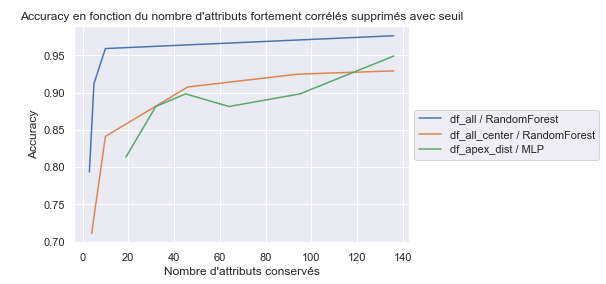

In [112]:
fig, ax = plt.subplots()

ax.plot(seuil_df_all[0],seuil_df_all[1],label='df_all / RandomForest')
ax.plot(seuil_df_all_center[0],seuil_df_all_center[1],label='df_all_center / RandomForest')
ax.plot(seuil_df_apex_dist[0],seuil_df_apex_dist[1],label='df_apex_dist / MLP')

plt.title("Accuracy en fonction du nombre d'attributs fortement corrélés supprimés avec seuil")
plt.xlabel("Nombre d'attributs conservés")
plt.ylabel('Accuracy')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
plt.show()

A l'aide du graphique ainsi obtenus et des résultats on peut observer que :

* Dans le cas des données non centrées la conservation de tous les attributs (les 136 coordonnées) permettent d'obtenir une précision maximale mais nous obtenus déjà plus de $0.95$ d'accuracy en ne conservant que très peu d'attributs (+/- 10)

* Dans le cas des données centrées où toutes les images sont considérés l'accuracy augmente en fonction du nombres d'attributs conservés, en ayant déjà une accuracy de plus de $0.9$ avec +/- 40 attributs conservés.

* Dans le cas où l'on considéré uniquement les images des distances entre neutre et apex on observe globalement qu'au plus le nombre d'attributs augmente au plus l'accuracy augmente avec $0.9$ déjà atteint pour +/- 40 attributs également.

Conclusion :

* Au vue des observations, on obtient d'excellent résultat quand l'on considère toutes les images en ne gardant qu'environ 10 points de coordonnées. Ce qui permet de limiter grandement la complexité du modèle au sens des attributs mais pas du nombre d'image à traitée. Par ailleurs qui nécessiste des données d'entraînement plus conséquente étant donner que celles-ci sont composées des images les moins expressives au plus expressives. De fait chaque sessions des opérateurs qui récoltent les images sont plus rigoureuses et demander un plus grand travail. On constate que la courbe avec centrage suit le comportement de celle sans centrage mais avec une accuracy bien plus faible.

* Au contraire, l'approche où l'on ne considère que la distance entre l'image neutre et l'image apex ne demande aux opérateurs la prise uniquement que de deux images (neutre et l'autre très expressive). De plus l'approche apex limite les données d'entraînement à une image considérée par session, celle de la distance entre la neutre et l'apex, mais l'on peut voir qu'il est nécessaire d'avoir au moins 40 attributs pour une accuracy de $0.9$. On a donc ici besoin de plus d'attributs mais avec un échantillon d'entraînement beaucoup plus faible.

* De par ce qui est ci-dessus, nous considérons l'approche apex_dist avec le MLP le meilleur compromis entre complexité et performance.

# 4 - Deuxième approche

* Dans cette approche nous allons sélectionner nos données de façon à obtenir un équilibre du rapport des distributions, c'est-à-dire que :

$$
C = \{happy, fear, surprise, anger, disgust, sadness\} \\
\\
\forall c_1, c_2 \in C, c_1 \neq c_2 \\
\textbf{on a :} \frac{\mathbb{P(Y=c_1)}}{\mathbb{P(Y=c_2)}} = 1
$$

* Ce qui équilibre le rapport de vraisemblance et donc rend équiprobable la prédiction d'une image à une émotion par rapport aux valeurs seuil de décision définies par l'entraînement du modèle sur les données en accord avec notre connaissance à priori du problème.

## 4.0 - Préparation des données

Dans cette deuxième approche nous allons étudier si le fait de garantir l'équilibre entre le nombre d'instances de chaque expression, fait varier nos résultats.

In [143]:
df_all_equi = df_all.loc[df_all['emotion'].isin(classes['id'])].groupby('emotion').head(np.min(df_all['emotion'].value_counts()))

In [144]:
df_all_center_equi = df_all_center.loc[df_all_center['emotion'].isin(classes['id'])].groupby('emotion').head(np.min(df_all_center['emotion'].value_counts()))

In [91]:
df_apex_equi = df_apex.loc[df_apex['emotion'].isin(classes['id'])].groupby('emotion').head(np.min(df_apex['emotion'].value_counts()))

In [92]:
df_apex_center_equi = df_apex_center.loc[df_apex_center['emotion'].isin(classes['id'])].groupby('emotion').head(np.min(df_apex_center['emotion'].value_counts()))

In [145]:
df_apex_dist_equi = df_apex_dist.loc[df_apex_dist['emotion'].isin(classes['id'])].groupby('emotion').head(np.min(df_apex_dist['emotion'].value_counts()))

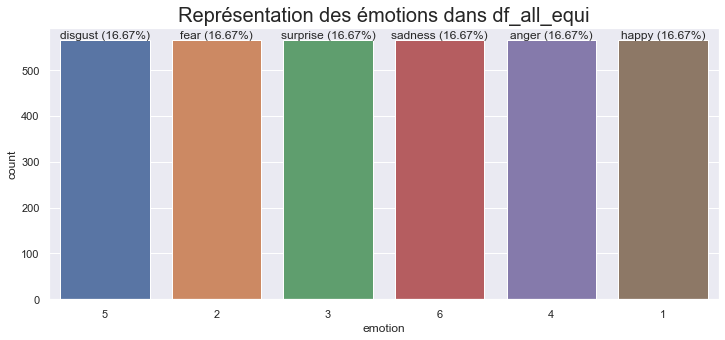

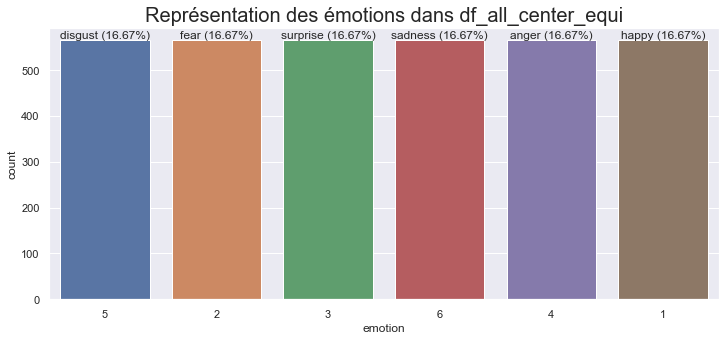

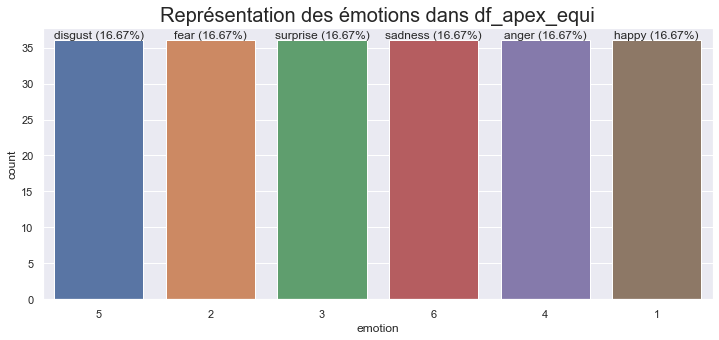

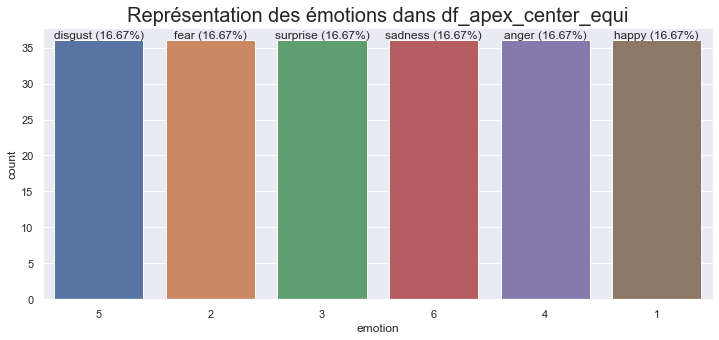

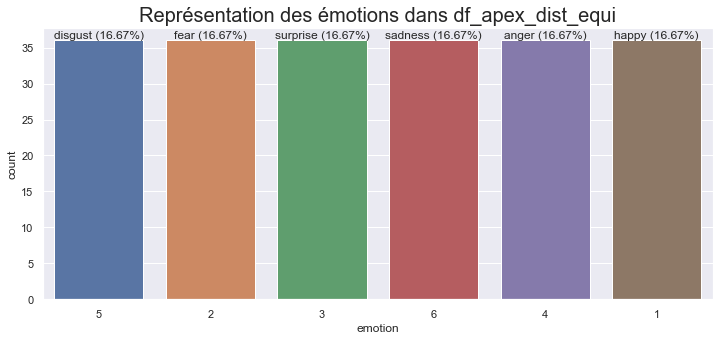

In [95]:
plt_reprensetation([df_all_equi,df_all_center_equi,df_apex_equi,df_apex_center_equi,df_apex_dist_equi],['df_all_equi','df_all_center_equi','df_apex_equi','df_apex_center_equi','df_apex_dist_equi'])

In [146]:
X_all_equi, y_all_equi = df_all_equi.loc[:,'x1':].values, df_all_equi['emotion'].values

In [147]:
X_all_center_equi, y_all_center_equi = df_all_center_equi.loc[:,'x1':].values, df_all_center_equi['emotion'].values

In [101]:
X_apex_equi, y_apex_equi = df_apex_equi.loc[:,'x1':].values, df_apex_equi['emotion'].values

In [102]:
X_apex_center_equi, y_apex_center_equi = df_apex_center_equi.loc[:,'x1':].values, df_apex_center_equi['emotion'].values

In [148]:
X_apex_dist_equi, y_apex_dist_equi = df_apex_dist_equi.loc[:,'x1':].values, df_apex_dist_equi['emotion'].values

In [104]:
data_equi = [(X_all_equi, y_all_equi,'df_all_equi'),(X_all_center_equi, y_all_center_equi,'df_all_center_equi'),(X_apex_equi,y_apex_equi,'df_apex_equi'),
             (X_apex_center_equi,y_apex_center_equi,'df_apex_center_equi'),(X_apex_dist_equi,y_apex_dist_equi,'df_apex_dist_equi')]

## 4.1 - Comparaison all vs  apex_dist

In [85]:
models = [RandomForestClassifier(n_jobs=-1),MLPClassifier(max_iter=5000)]
param = [rf_param_grid, mlp_param_grid]

In [109]:
warnings.filterwarnings('ignore') # for GS with MLP:  lbfgs failed to converge
i = 0 
for X,y,label in data_equi:
    if "apex" in label:
        i = 1
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)
    
    gs = GridSearchCV(estimator=models[i], param_grid = param[i],n_jobs=-1).fit(X_train,y_train)

    print(f'{label} : {gs.score(X_test,y_test)}')
warnings.filterwarnings('default')

df_all_equi : 0.9874664279319606
df_all_center_equi : 0.9319606087735004
df_apex_equi : 0.7638888888888888
df_apex_center_equi : 0.7222222222222222
df_apex_dist_equi : 0.9166666666666666


* On constate que l'approche apex simple avec ou sans centrage n'est pas satisfaisante si l'on compare avec les autres approches.
* Dans le cas all_equi on a une légère amélioration de l'accuracy de 0.01
* Pour all_center l'accuracy est équivalente
* Enfin pour l'approche apex_dist on constante une diminution de +/- 0.03

## 4.2- Avec exclusion des attributs fortement corrélés

Observons maintenant si dans le cas où le nombre d'instances est équilibré et où des attributs fortement corrélés ne sont pas conservés une variation de la précision est observée

In [165]:
seuil_df_all_equi = search_best_seuil(RandomForestClassifier(),rf_param_grid,df_all_equi,verbose=True)

threshold : 0.95, accuracy : 0.8299015219337511 +/- 0.02, with 3 attr
threshold : 0.97, accuracy : 0.9265890778871978 +/- 0.01, with 5 attr
threshold : 0.99, accuracy : 0.973142345568487 +/- 0.01, with 11 attr
threshold : None, accuracy : 0.982094897045658 +/- 0.01, with  136 attr


In [166]:
seuil_df_all_center_equi = search_best_seuil(RandomForestClassifier(),rf_param_grid,df_all_center_equi,threshold=[0.99,0.995,0.999,0.9999],verbose=True)

threshold : 0.99, accuracy : 0.6705461056401074 +/- 0.02, with 3 attr
threshold : 0.995, accuracy : 0.8683974932855864 +/- 0.02, with 10 attr
threshold : 0.999, accuracy : 0.9077887197851388 +/- 0.02, with 46 attr
threshold : 0.9999, accuracy : 0.9292748433303492 +/- 0.02, with 93 attr
threshold : None, accuracy : 0.927484333034915 +/- 0.02, with  136 attr


In [167]:
seuil_df_apex_equi = search_best_seuil(MLPClassifier(),mlp_param_grid,df_apex_dist_equi,threshold=[0.90,0.93,0.95,0.97,0.99],verbose=True)

threshold : 0.9, accuracy : 0.8888888888888888 +/- 0.05, with 15 attr
threshold : 0.93, accuracy : 0.9305555555555556 +/- 0.05, with 28 attr
threshold : 0.95, accuracy : 0.8333333333333334 +/- 0.06, with 41 attr
threshold : 0.97, accuracy : 0.8472222222222222 +/- 0.06, with 61 attr
threshold : 0.99, accuracy : 0.9027777777777778 +/- 0.06, with 97 attr
threshold : None, accuracy : 0.9444444444444444 +/- 0.05, with  136 attr


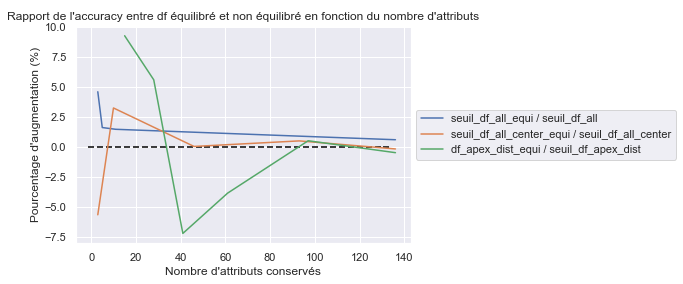

In [212]:
fig, ax = plt.subplots()


ax.plot(seuil_df_all_equi[0],(seuil_df_all_equi[1]/seuil_df_all[1])*100-100,label='seuil_df_all_equi / seuil_df_all')
ax.plot(seuil_df_all_center_equi[0],(seuil_df_all_center_equi[1]/seuil_df_all_center[1])*100-100,label='seuil_df_all_center_equi / seuil_df_all_center')
ax.plot(seuil_df_apex_equi[0],(seuil_df_apex_equi[1]/seuil_df_apex[1])*100-100,label='df_apex_dist_equi / seuil_df_apex_dist')
ax.scatter(np.arange(0,136,4),np.repeat(0,136/4),color='black',marker='_')

plt.ylabel("Pourcentage d'augmentation (%)")
plt.xlabel("Nombre d'attributs conservés")
plt.title("Rapport de l'accuracy entre df équilibré et non équilibré en fonction du nombre d'attributs")
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
plt.show()

* On constate à l'aide de ce graphe que l'équilibrage du rapport des distributions est bénéfique en terme d'accuracy dans certains cas en fonction des données :
    * Dans le cas df_all, on observe une augmentation max de presque 5% avec peu d'attributs, augmentation qui diminue avec le nombre d'attributs conservés mais qui reste positif mais très légère.
    * Pour df_all_center, on a une augmentation max de 3% pour environ 10 attributs conservés puis une stabilisation proche de 0% en augmentant le nombre d'attributs
    * Enfin pour df_apex_dist, nous avons 9% d'augmentation de l'accuracy pour +/- 15 attributs conservés puis une diminution du rapport.

* On peut donc conclure que l'équilibrage permet d'améliorer le modèle dans le cas apex_dist avec le MLPClassifier
    
* Pour aller plus loin on pourrait s'intéresser à un graphe du même type mais en prenant le rapport sur la macro et micro average du $F_1$ score. On va se contenter ici de regarder celui-ci dans le cas df_apex_dist_equi / df_apex_dist :

In [219]:
from sklearn.metrics import f1_score

f1_apex = []

for X,y in [(X_apex_dist_equi,y_apex_dist_equi),(X_apex_dist,y_apex_dist)]:
    df_drop = df_apex_dist.drop(columns=get_correlation_drop(df_apex_dist,threshold=0.9))
    
    X = StandardScaler().fit_transform(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)
    gs_t = GridSearchCV(estimator=MLPClassifier(max_iter=5000), param_grid = mlp_param_grid,n_jobs=-1).fit(X_train,y_train)
    
    f1_apex += [f1_score(y_test,gs_t.predict(X_test),average=m) for m in ['micro','macro']]

In [223]:
np.array(f1_apex[:2])/np.array(f1_apex[2:])*100-100

array([-1.66666667, -2.11043567])

* Ainsi on peut voir que l'on arrive à augmenter de 9% l'accuracy avec df_apex_dist_equi tout en gardant stable la micro et macro average du $F_1$ score

**Conclusion :** 

Cette approche permet dans certains cas où l'on considère un nombre réduit d'attributs d'augmenter l'accuracy tout en gardant un f1 score stable.
Elle est notamment intéressante à utiliser dans le cas apex_dist avec 15 attributs.

# 5 - Troisième approche

Dans cette troisième approche nous allons étudier les performances en présence d'occultations et bruitages faciaux. Dans le but de savoir jusqu'à quel point les techniques d'apprentissage proposées dans les démarches précédentes sont robustes à ces altérations et bruitages en termes d'étendue et d'intensité. 

In [258]:
def get_range_points(start,end):
    """
    Return the label ist of x coordinate and y coordinate two by two
    from start to end
    
    :param start: starting coordinates
    :param end: ending coordinates
    
    :type start: int
    :type end: int
    
    :return: the list of x,y coordinate two by two from start to end index
    :rtype: np.array
    """
    res = []
    for i in range(start,end+1):
        res += [f'x{i}', f'y{i}']
    return np.asarray(res)

In [259]:
def add_noise(X,mu,sigma):
    """
    
    Add noises to X data by using random samples from a normal (Gaussian) distribution
    of center mu and std sigma
    
    :param X: sample of data to add noises
    :param mu: Mean (“centre”) of the distribution.
    :param sigma: Standard deviation (spread or “width”) of the distribution. Must be non-negative.
    
    :type X: np.ndarray
    :type mu: int
    :type sigma: int
    
    :return:
    :rtype: nd.ndarray
    """
    return X + np.random.normal(mu, sigma, X.shape)

In [273]:
def get_score_region(estimator,param_grid,df,selected_regions,noise=(0,30,False),verbose=False):
    """
    Perform a GridSearchCV on estimator with given the selectd face regions in df
    
    :param estimator: the model of prediction
    :param param_grid: dict of param for gridsearch
    :param df: the dataframe with data to use
    :param selected_regions: the face regions to consider
    :param noise: the noises param to add on training data
    :param verbose: verbosity
    
    :type esitmator: sklearn model
    :type param_grid: Dict
    :type df: pd.DataFrame
    :type selected_regions: List
    :type noise: Tuple
    :type verbose: Bool
    
    :return: the list of test accuracy of gridsearchcv performed for each selected regions
    :rtype: np.array
    """
    res = []
    y =  df['emotion'].values

    if verbose: print(estimator)
        
    for regions in selected_regions:    
        X = df.loc[:,np.concatenate([d_regions[r] for r in regions])].values
        
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=0)
        if noise[-1]:
            X_train = add_noise(X_train,noise[0],noise[1])
            
        ss = StandardScaler().fit_transform(X,y)
        X_train, X_test = ss.transform(X_train), ss.transform(X_test)
            
        gs = GridSearchCV(estimator=estimator, param_grid = param_grid,n_jobs=-1).fit(X_train,y_train)
        
        score = gs.score(X_test,y_test)
        res += [score]
    
        if verbose: print(f'\t {regions} : {score}')
        
    return np.asarray(res)

In [274]:
def plt_score_region(scores,selected_regions,labels):
    """
    
    Plot the given result of performed experiments for the given selected regions
    
    :param scores: result in terms of accuracy of the experiment
    :param selected_regions: list of face regions to consider
    param labels: labels of corresponding scores results
    
    :type scores: np.array
    :type selected_regions: List
    :type labels: List
    """
    
    fig, aux = plt.subplots(figsize=(30,15))
    x = np.linspace(1,len(selected_regions),len(selected_regions))
    
    for i in range(len(scores)):
        plt.plot(x,scores[i],label=labels[i])
    
    plt.xticks(x,selected_regions,fontsize=10)
    plt.title("Précision en fonction d'une sélection de régions du visage")
    plt.xlabel('Régions')
    plt.ylabel('Précision')
    plt.legend(loc='best')

In [275]:
d_regions = {'left eye' : get_range_points(37,42), 'right eye' : get_range_points(43,48),
           'noise' : get_range_points(28,36), 'mouth' : get_range_points(49,68),
           'left eyebrow' : get_range_points(18,22), 'right eyebrow' : get_range_points(23,27),
           'face outline' : get_range_points(1,17)}

Nous faisons le choix de prendre les combinaisons de régions suivantes :

* Mouth
* Left eye + Right eye
* Left eye + Right eye + Mouth
* Left eyebrow + Right eyebrow
* Left eyebrow + Right eyebrow + Mouth
* Left eye + Right eye + Left eyebrow + Right eyebrow 
* Left eye + Right eye + Left eyebrow + Right eyebrow + Mouth

In [276]:
selected_regions = [['mouth'],['left eye', 'right eye'], ['left eyebrow', 'right eyebrow'],
           ['left eye', 'right eye', 'left eyebrow', 'right eyebrow', 'mouth'],
          ['left eye', 'right eye', 'left eyebrow', 'right eyebrow'],
          ['left eyebrow', 'right eyebrow', 'mouth'],
           ['left eye', 'right eye','mouth']]

### 5.1 - Sans bruitage

* Nous faisons le choix de nous intéresser qu'aux données df_all et df_apex_dist de part les conclusions précédentes incluants l'accuracy avec exclusion d'attributs. Qui ici ce que nous allons faire mais en se basant sur des zones du visages et non sur le degré de corrélation des coordonnées.

In [278]:
score_regions = [get_score_region(estimator,param,df,selected_regions,verbose=True)
                 for estimator,param,df in [(RandomForestClassifier(n_jobs=-1),rf_param_grid,df_all),(MLPClassifier(max_iter=5000),mlp_param_grid,df_apex_dist)]]

RandomForestClassifier(n_jobs=-1)
	 ['mouth'] : 0.9464110127826942
	 ['left eye', 'right eye'] : 0.9444444444444444
	 ['left eyebrow', 'right eyebrow'] : 0.9346116027531957
	 ['left eye', 'right eye', 'left eyebrow', 'right eyebrow', 'mouth'] : 0.9714847590953786
	 ['left eye', 'right eye', 'left eyebrow', 'right eyebrow'] : 0.9655850540806293
	 ['left eyebrow', 'right eyebrow', 'mouth'] : 0.9690265486725663
	 ['left eye', 'right eye', 'mouth'] : 0.9709931170108161
MLPClassifier(max_iter=5000)
	 ['mouth'] : 0.864406779661017
	 ['left eye', 'right eye'] : 0.6101694915254238
	 ['left eyebrow', 'right eyebrow'] : 0.5932203389830508
	 ['left eye', 'right eye', 'left eyebrow', 'right eyebrow', 'mouth'] : 0.940677966101695
	 ['left eye', 'right eye', 'left eyebrow', 'right eyebrow'] : 0.7627118644067796
	 ['left eyebrow', 'right eyebrow', 'mouth'] : 0.923728813559322
	 ['left eye', 'right eye', 'mouth'] : 0.8813559322033898


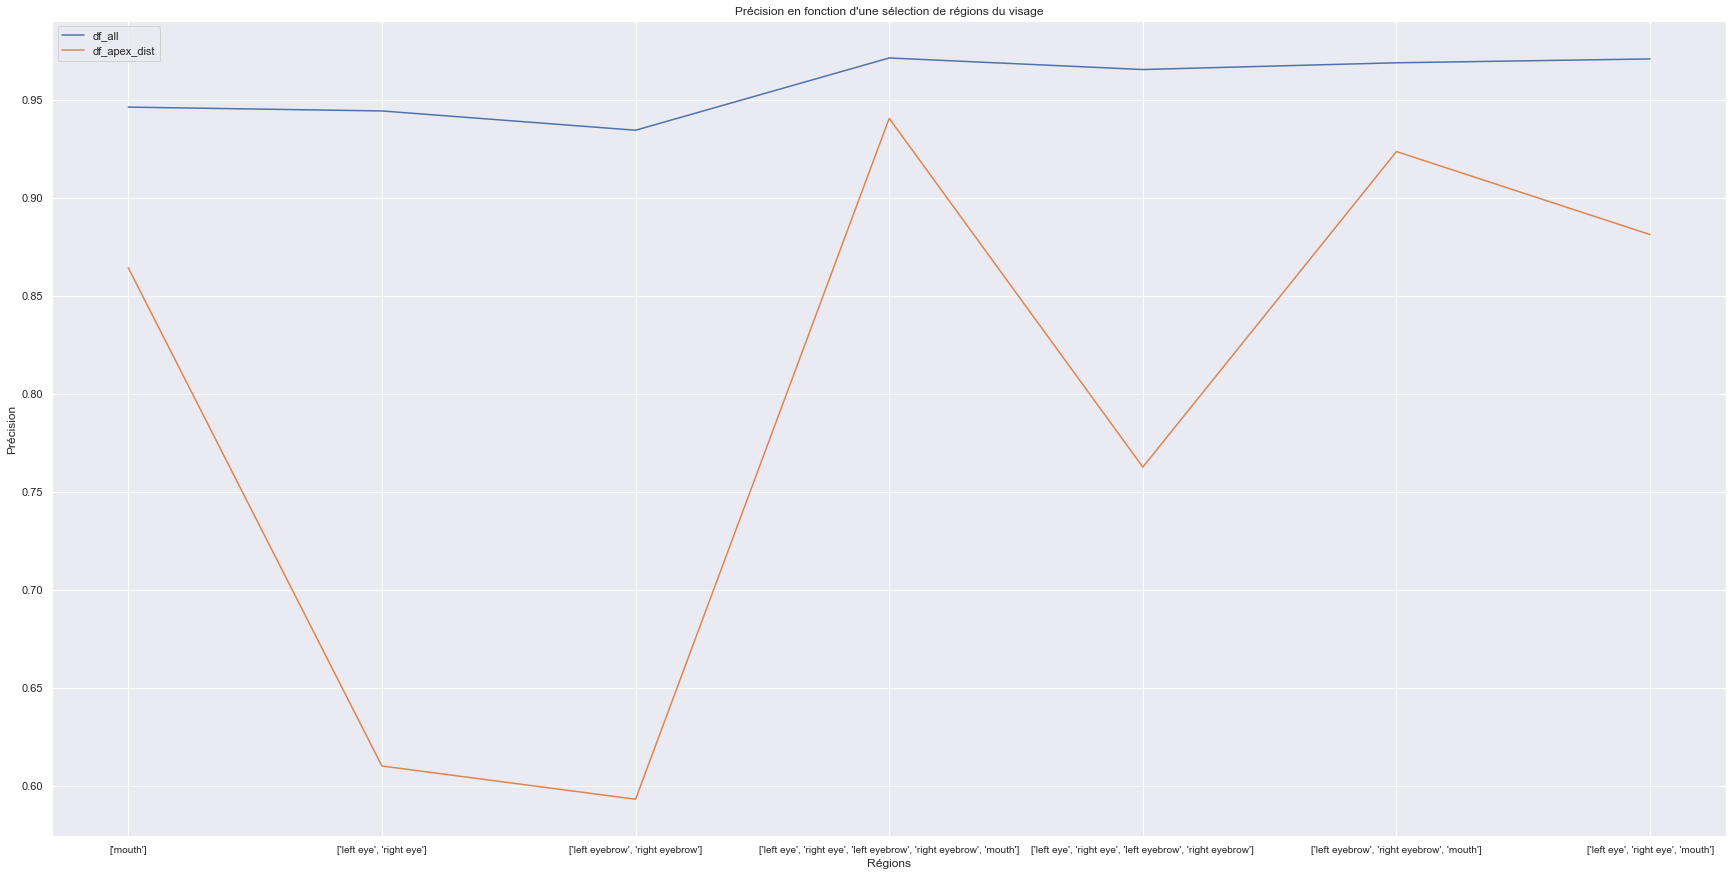

In [281]:
plt_score_region(score_regions,selected_regions,['df_all','df_apex_dist'])

* On peut ainsi constater à l'aide de ce graphique que les sélections de régions qui ne contienent pas la bouche ou les sourcirls sont sujets à des pertes en précision du modèle. Les meilleurs scores sont obtenus par la combinaisons de la bouche, des sourcils et des yeux.

* Dans le cas où l'on considère uniquement la bouche on peut voir qu'avec df_all on est à $0.94$ de précision et pour df_apex_dist $0.86$.

* La courbe de df_all reste assez constante par rapport au point où l'on prend que la bouche ainsi la sélection uniquement de la bouche dans ce cas est pertinant. Au contraire du df_apex_dist qui n'a pas de résultats stable.

* On peut donc tendre à penser sur le fait que les points qui apportent le plus d'expressivité par rapport à l'expression du visage sont les points de la bouche, puis des sourcils et des yeux. Surtout pour la bouche qui obtient à elle seule presque des aussi bonne accuracy que sans occultation du visage

### 5.2 - Avec bruitage

* Nous allons considérer uniquement certaines régions au vue des résultats précédents sans bruitage :

In [283]:
selected_regions_2 = [['mouth'],['left eye', 'right eye', 'left eyebrow', 'right eyebrow', 'mouth'],
                    ['left eyebrow', 'right eyebrow', 'mouth'],
                    ['left eye', 'right eye','mouth']]


* Observons maintenant avec l'ajout d'un bruit centré en 0 avec un écart type de 30 suivant une loi normale gaussienne dans nos données en entraînement avec sélection de régions du visage :

In [284]:
score_regions_noise = [get_score_region(estimator,param,df,selected_regions_2,noise=(0,30,True),verbose=True)
                 for estimator,param,df in [(RandomForestClassifier(n_jobs=-1),rf_param_grid,df_all),(MLPClassifier(max_iter=5000),mlp_param_grid,df_apex_dist)]]

RandomForestClassifier(n_jobs=-1)
	 ['mouth'] : 0.4724680432645034
	 ['left eye', 'right eye', 'left eyebrow', 'right eyebrow', 'mouth'] : 0.5034414945919371
	 ['left eyebrow', 'right eyebrow', 'mouth'] : 0.516715830875123
	 ['left eye', 'right eye', 'mouth'] : 0.4970501474926254
MLPClassifier(max_iter=5000)
	 ['mouth'] : 0.5423728813559322
	 ['left eye', 'right eye', 'left eyebrow', 'right eyebrow', 'mouth'] : 0.6440677966101694
	 ['left eyebrow', 'right eyebrow', 'mouth'] : 0.6101694915254238
	 ['left eye', 'right eye', 'mouth'] : 0.5254237288135594


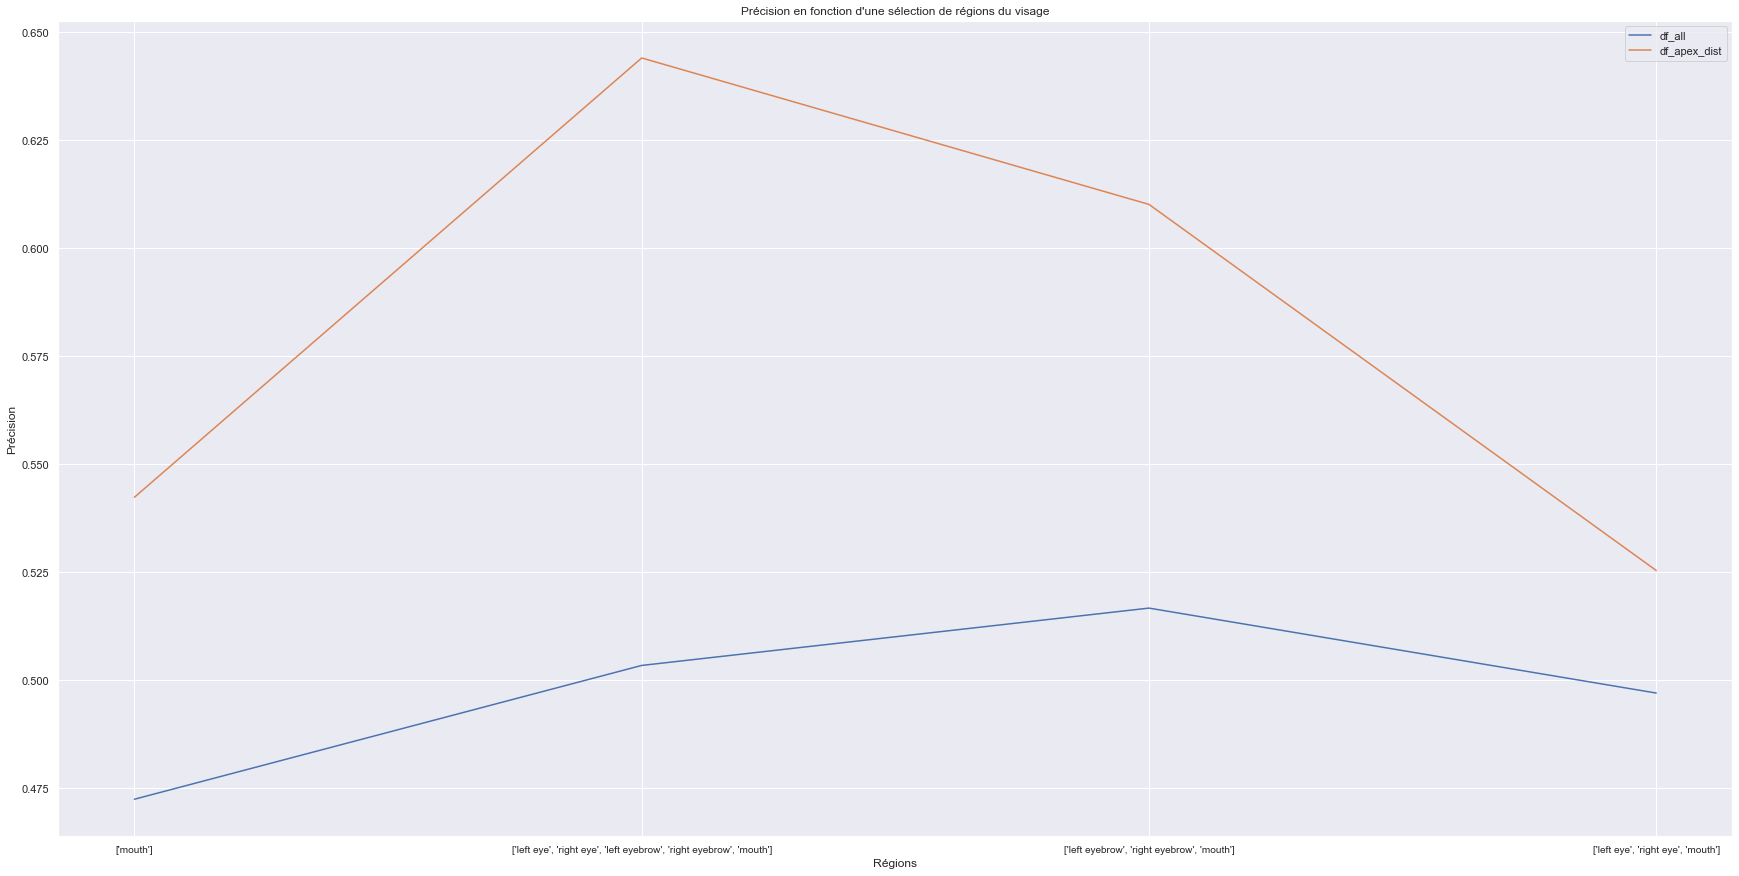

In [288]:
plt_score_region(score_regions_noise,selected_regions_2,['df_all','df_apex_dist'])

* On peut constater que l'ajout du bruit assez conséquent avec un std de 30 combiné avec des occultations de régions du visage fait chuter la précision de notre modèle presque au moins de moitié dans certains cas
* A l'aide du graphique on peut constater en comparaison du même graphique sans bruitage que dans ce cas présent avec bruitage, la présence de la bouche dans les zones considérés du visage en entraînement permet de faire moins chuter la précision si l'on compare avec les autres régions.
* L'ajout du bruit a un impact beaucoup plus important que l'occultation de régions du visage sur la capacité prédictive de notre modèle 

* L'approche par apex_dist subit un impact moins important sur son accuracy que l'approche avec toutes les images

* Voyons avec un bruit moins important maintenant centré en 0 avec écart type de 15 :

In [291]:
score_regions_noise_15 = [get_score_region(estimator,param,df,selected_regions_2,noise=(0,15,True),verbose=True)
                 for estimator,param,df in [(RandomForestClassifier(n_jobs=-1),rf_param_grid,df_all),(MLPClassifier(max_iter=5000),mlp_param_grid,df_apex_dist)]]

RandomForestClassifier(n_jobs=-1)
	 ['mouth'] : 0.5816125860373648
	 ['left eye', 'right eye', 'left eyebrow', 'right eyebrow', 'mouth'] : 0.6465093411996067
	 ['left eyebrow', 'right eyebrow', 'mouth'] : 0.6529006882989183
	 ['left eye', 'right eye', 'mouth'] : 0.619960668633235
MLPClassifier(max_iter=5000)
	 ['mouth'] : 0.6949152542372882
	 ['left eye', 'right eye', 'left eyebrow', 'right eyebrow', 'mouth'] : 0.7627118644067796
	 ['left eyebrow', 'right eyebrow', 'mouth'] : 0.7542372881355932
	 ['left eye', 'right eye', 'mouth'] : 0.7711864406779662


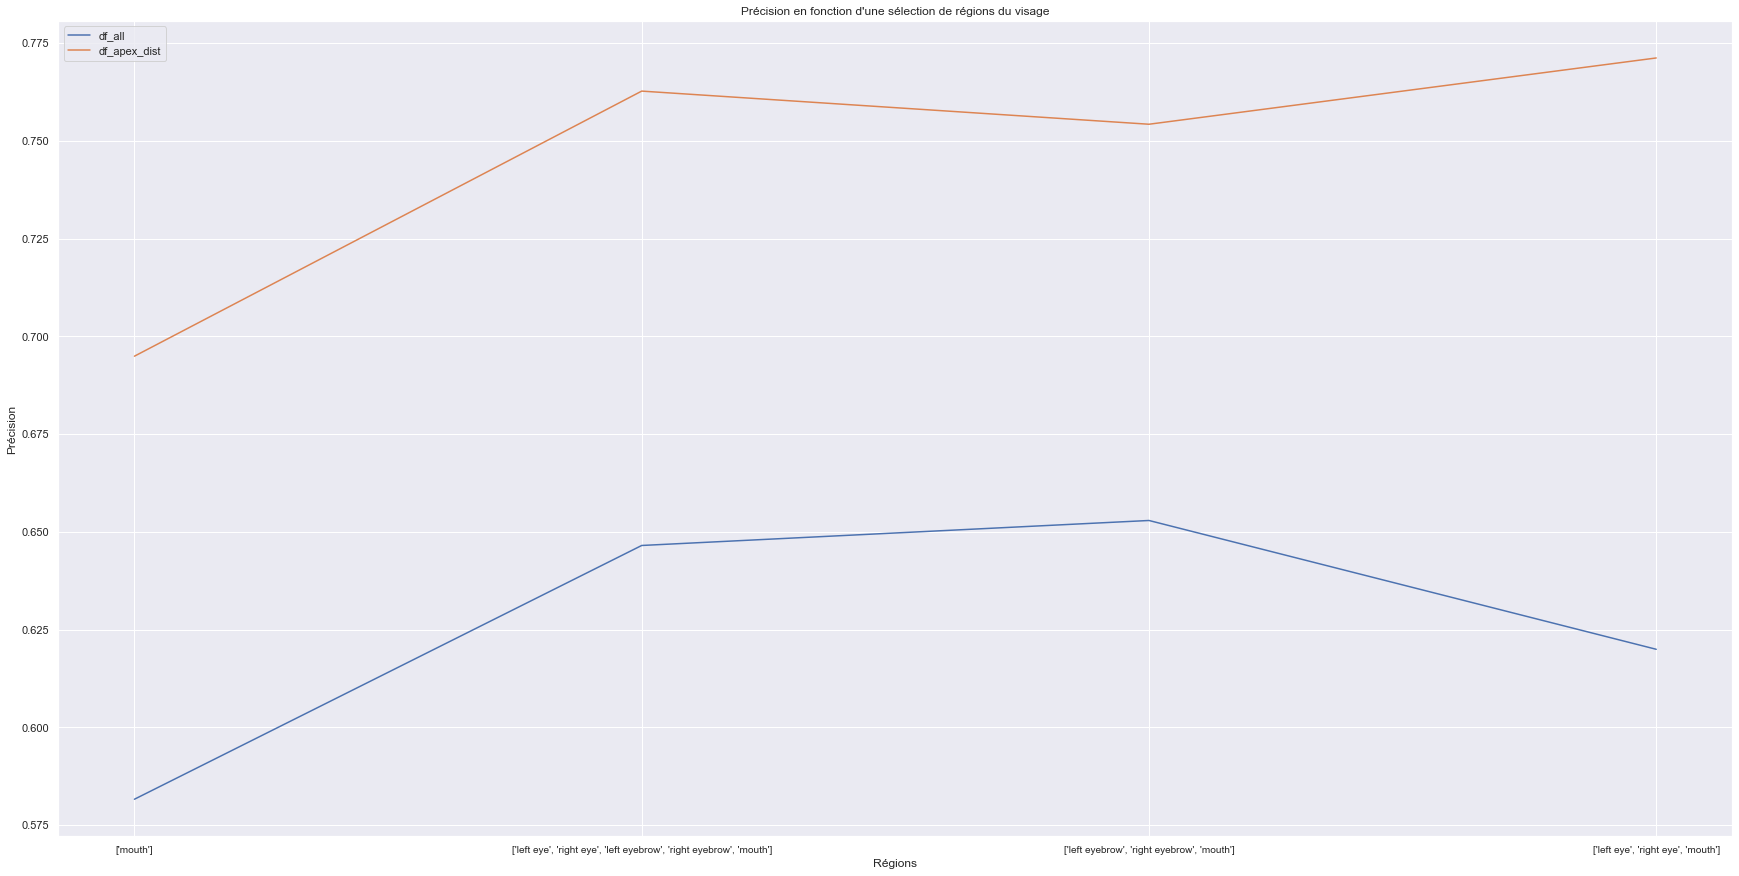

In [292]:
plt_score_region(score_regions_noise_15,selected_regions_2,['df_all','df_apex_dist'])

* On peut constater qu'avec un bruit deux fois moins important on obtient les mêmes comportements de courbes pour les mêmes régions sélectionnées
* On peut observer également que le bruit étant moins important, son impact sur la précision l'est aussi mais reste tout de même assez conséquent par rapport au précision obtenues avec un entraînement sans bruitage et avec uniquement occultations que nous avons pu observer précédemment

**En conclusion de cette troisième approche :**

* Nous avons pu constater que l'occultation de zones du visage pouvait avoir des conséquences importantes sur la capacité de prédiction de notre modèle en fonction des zones retenues précisément, plus que du nombre de zones occultées comme on pourrait le penser sans observation.
* Ainsi nous avons pu dans un premier temps mettre en évidence l'importante expressivité/quantité d'information qu'apportent certaines zones du visage pour la prédiction, comme la présence ou non des points de coordonnées de la bouche.

* Dans un deuxième temps nous avons en addition à ces occultations, ajouter un bruitage que nous avons réduit ensuite. Ce qui nous a permis de constater que le bruitage des coordonnées des points données en apprentissage à notre modèle influer beaucoup plus que l'occultation de zones du visage.
* Avec un bruitage suivant une loi normale (0,30) nous avons pu voir la précision descendre de moitié au minimum dans la majorité des cas, cette chute de précision est atténuer en réduisant l'intervalle que suit la loi normale.

# 6 - Approche par Stacking 

* Dans cette partie nous proposons d'effectuer un stacking des meilleures modèles que nous avons pu étudier dans ce projet, à savoir :

    * RandomForestClassifier
    * DecisionTreeClassifier
    * KNeighborsClassifier
    * MLPClassifier
    * LogisticRegression


Un StackingClassifier est une méthode d'ensemble dans laquelle la sortie de plusieurs classifier est transmise en entrée à un méta-classifier pour la prédiction finale. Les modèles de classifier individuels sont entraînés sur la base de l'ensemble de training complet puis le meta-classifier est ajusté en se basant sur les sorties, nommés méta-caractéristiques, des modèles individuels :

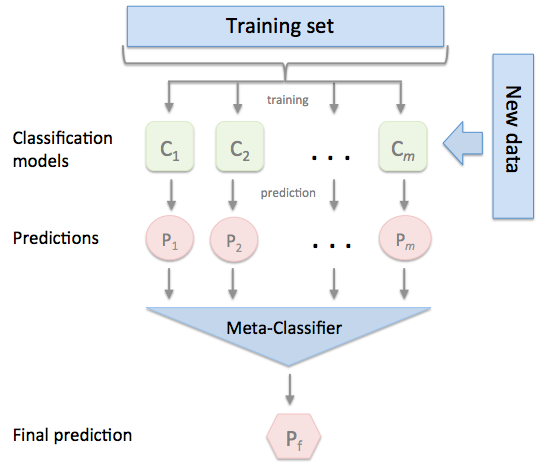

### 6.1 - Level-0 avec tous nos modèles

In [311]:
estimators = []
estimators.append(('Decision Tree Classifier', DecisionTreeClassifier()))
estimators.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
estimators.append(('LogisticRegression', LogisticRegression(max_iter=1000)))
estimators.append(('MLPClassifier', MLPClassifier(max_iter=2000)))
estimators.append(('RandomForest', RandomForestClassifier(max_depth= 10, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 170)))


In [293]:
models_selection = [RandomForestClassifier(n_jobs=-1), DecisionTreeClassifier(), 
                    KNeighborsClassifier(n_jobs=-1), MLPClassifier(max_iter=1000), 
                    LogisticRegression(max_iter=100,n_jobs=-1)]

### 6.2 - Level-1 modèle

In [384]:
final_all = RandomForestClassifier(n_jobs=-1)
final_apex = MLPClassifier(max_iter=5000)

### 6.3 - Stacking

In [335]:
from sklearn.ensemble import StackingClassifier
from sklearn.multiclass import OneVsRestClassifier
from statistics import stdev
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve

In [393]:
SC_all = StackingClassifier(estimators=estimators,final_estimator=final_all,cv=3)
SC_apex = StackingClassifier(estimators=estimators,final_estimator=final_apex,cv=3)

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,random_state=0,test_size=0.33)

ovr_model = OneVsRestClassifier(SC_all)
ovr_model.fit(X_train,y_train)
y_pred_all = ovr_model.predict(X_test)
print(f"df_all :\n\n\tStackingClassifier test acc : {ovr_model.score(X_test, y_test):0.2f}")

df_all :

	StackingClassifier test acc : 0.97


* Nous faisons le choix ici de l'heuristique OneVsRest (ovr)

In [381]:
print(classification_report(y_test,ovr_model.predict(X_test),target_names=classes.values[:,1]))

              precision    recall  f1-score   support

       happy       0.97      0.98      0.98       598
        fear       0.96      0.95      0.96       259
    surprise       0.98      0.94      0.96       406
       anger       0.97      0.98      0.98       258
     disgust       0.94      0.97      0.96       179
     sadness       0.97      0.99      0.98       334

    accuracy                           0.97      2034
   macro avg       0.97      0.97      0.97      2034
weighted avg       0.97      0.97      0.97      2034



* On peut constater que nous obtenons une très bonne acurracy accompagné d'une très bonne macro et micro average du $F_1$ score tous à $0.97$.
Si l'on reprend les meilleures résultats dans le cas df_all nous avions $0.93$ en comparaison.

* Nous avons pas chercher à optimiser les hyper-paramètres des modèles et pourtant on obtient une bonne amélioration des metrics.Le Stacking est donc très intéressant ici.

* Regardons maintenant sur le df_apex_dist : 

In [394]:
X_train, X_test, y_train, y_test = train_test_split(X_apex_dist,y_apex_dist,random_state=0,test_size=0.33)

ovr_model = OneVsRestClassifier(SC_apex)
ovr_model.fit(X_train,y_train)
y_pred_apex = ovr_model.predict(X_test)
print(f"df_apex_dist :\n\n\tStackingClassifier test acc : {ovr_model.score(X_test, y_test):0.2f}")

df_apex_dist :

	StackingClassifier test acc : 0.92


In [395]:
print(classification_report(y_test,ovr_model.predict(X_test),target_names=classes.values[:,1]))

              precision    recall  f1-score   support

       happy       0.97      1.00      0.98        28
        fear       0.95      0.91      0.93        22
    surprise       0.96      0.88      0.92        26
       anger       1.00      0.82      0.90        11
     disgust       1.00      1.00      1.00        10
     sadness       0.76      0.90      0.83        21

    accuracy                           0.92       118
   macro avg       0.94      0.92      0.93       118
weighted avg       0.93      0.92      0.92       118



* Dans le cas apex_dist, le meilleur modèle MLP avait obtenu $0.95$ en acurracy, macro et micro average. Hors ici on obtient $0.95$

* L'approche avec Stacking et OneVsRest permet dans le cas où l'on considère toutes les données de pouvoir obtenir un bon modèle en terme d'accuracy, macro et micro average et cela sans recherche par grille des hyperparamètres.
* Ainsi si l'on devrait conclure sur la meilleure approche celle par Stacking et OvR avec df_all est la meilleure, la seconde serait df_apex_dist avec le MLP